We know from the data card that this is synthetic data, so we know we are facing challenges understanding it correctly. Fundamentally, we want to filter out data that is questionable and then look for a part of the data where we might expect to find cheaters. For our purposes, cheaters are people who use Stockfish to suggest their moves an unusual amount. In the real world, we would expect people with low Elo scores to play Stockfish moves rarely, and people with high Elo scores to play Stockfish moves relatively often, but of course in instances where only one move is possible even someone with an Elo score of zero will play the same move Stockfish would play, so we never know for sure.

In [1]:
import pandas as pd

DATA = '/kaggle/input/chess-cheating-dataset/Games.csv'
df = pd.read_csv(filepath_or_buffer=DATA)
df.head()

,Liste cheat white,Liste cheat black,Game,Elo White,Elo Black,Score
0,00000000001111101010111010100110000001001111,0000000000111001000000001100100000000111000,1. d4 e6 2. c4 d5 3. Nc3 Be7 4. Nf3 Nf6 5. Bf4...,1001,-1,1/2-1/2
1,0000000000000010111101100000100111000111101111001,0000000000110111110111111111111111111011111111111,1. d4 c5 2. c4 cxd4 3. Qxd4 Nc6 4. Qd1 e6 5. N...,1001,-1,1/2-1/2
2,0000000000111001110111100111111110101011110111...,0000000000111111100001111111111111111111010101...,1. e4 e5 2. d4 exd4 3. Qxd4 Nc6 4. Qd3 b6 5. B...,1001,-1,1/2-1/2
3,000000000011111101111111110110101111111,00000000000001101001000011100111100110,1. e4 e5 2. Nf3 Nf6 3. Nc3 Bc5 4. Bc4 d6 5. O-...,1002,-1,1/2-1/2
4,0000000000001000111010111101001010011010011011...,0000000000000000010000001110011010100010001100...,1. d4 d5 2. c4 Nf6 3. Nc3 e6 4. Bg5 Be7 5. e3 ...,1002,-1,1/2-1/2


First of all, how many examples of each score do we have?

In [2]:
df['Score'].value_counts().to_dict()

{'0-1': 21126, '1-0': 19484, '1/2-1/2': 8323}

It is kind of a surprise that Black would win substantially more games than White since White starts the game with a tempo advantage. We expect there to be some draws, but it's hard to have a good prior.

In [3]:
df[(df['Elo White'] > 0) & (df['Elo Black'] > 0)]['Score'].value_counts(normalize=True).to_dict()

{'0-1': 0.43421704391273447,
 '1-0': 0.39990954708935456,
 '1/2-1/2': 0.16587340899791098}

Once we ignore negative Elo scores we see that we have roughly 16.6 pct draws. If we just look at the Black and White win share what do we see?

In [4]:
df[(df['Elo White'] > 0) & (df['Elo Black'] > 0) & (df['Score'] != '1/2-1/2')]['Score'].value_counts(normalize=True).to_dict()

{'0-1': 0.5205649221553794, '1-0': 0.4794350778446206}

Our dataset shows White winning only 48 pct of games that are not draws and have meaningful Elo scores.

Its hard to make sense of negative Elo scores, so let's look at the distribution of scores without them.

<Axes: xlabel='Elo White', ylabel='Elo Black'>

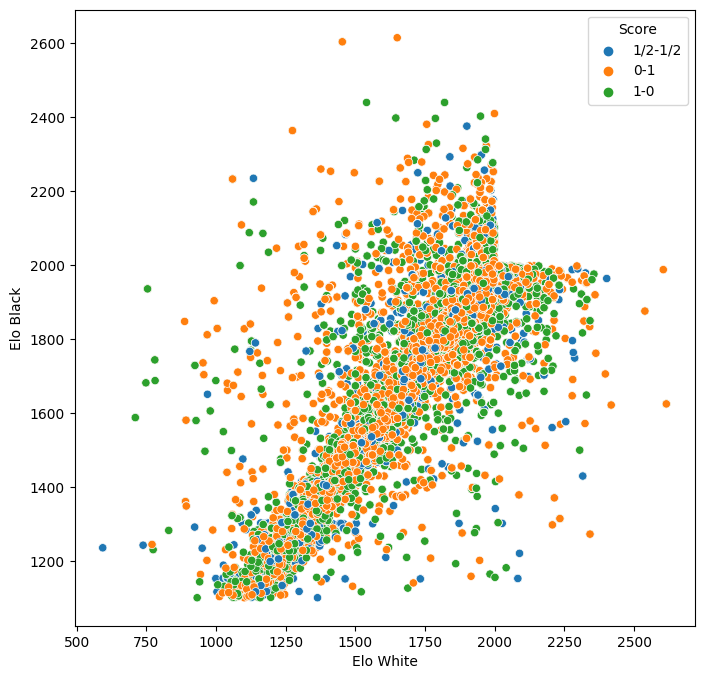

In [5]:
import matplotlib.pyplot as plt
from seaborn import scatterplot

plt.figure(figsize=(8, 8))
scatterplot(data=df[(df['Elo White'] > 0) & (df['Elo Black'] > 0)], x='Elo White', y='Elo Black', hue='Score')


That notch in the upper right corner looks odd.

This plot really calls out for a facet plot. Let's try that.

In [6]:
from plotly import express

express.scatter(data_frame=df[(df['Elo White'] > 0) & (df['Elo Black'] > 0)], x='Elo White', y='Elo Black', color='Score', facet_col='Score')

In [7]:
express.density_contour(data_frame=df[(df['Elo White'] > 0) & (df['Elo Black'] > 0)], x='Elo White', y='Elo Black',  color='Score', facet_col='Score',)

Let's add some features that will tell us the proportion of Stockfish moves for both Black and White.

In [8]:
df['W moves'] = df['Liste cheat white'].str.len()
df['B moves'] = df['Liste cheat black'].str.len()
df['W SF count'] = df['Liste cheat white'].apply(func=lambda x: str(x).count('1'))
df['B SF count'] = df['Liste cheat black'].apply(func=lambda x: str(x).count('1'))
df['W SF pct'] = df['W SF count']/df['W moves']
df['B SF pct'] = df['B SF count']/df['B moves']
df['W SF pct'].max(), df['B SF pct'].max()

(0.9364161849710982, 0.9230769230769231)

Now we can scatter plot using the percentage of moves that Black and White make that are Stockfish moves. 

In [9]:
express.scatter(data_frame=df[(df['Elo White'] > 0) & (df['Elo Black'] > 0)], x='W SF pct', y='B SF pct', color='Score', facet_col='Score')

What do we see? We see that generally the more moves a player makes that correspond to what Stockfish would do in the same situation, the more likely that player is to win. And in draws the Stockfish percentages are roughly equally distributed.

<Axes: xlabel='Elo White', ylabel='Elo Black'>

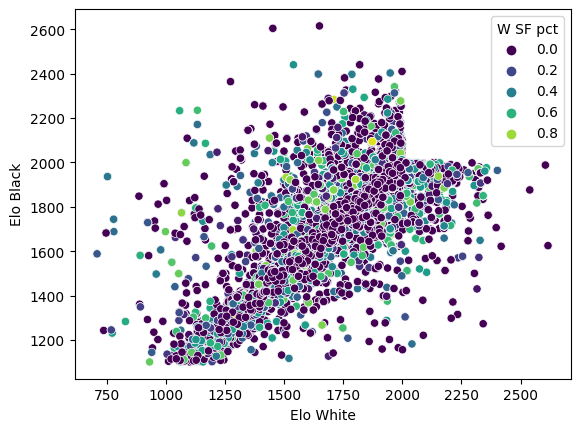

In [10]:
scatterplot(data=df[(df['Elo White'] > 0) & (df['Elo Black'] > 0) & (df['Score'] != '1/2-1/2')], x='Elo White', y='Elo Black', hue='W SF pct', palette='viridis')


How many of our Stockfish percentages are zero?

In [11]:
len(df), len(df[(df['W SF pct'] == 0.0) | (df['B SF pct'] == 0.0)]), len(df[df['W SF pct'] == 0.0]), len(df[df['B SF pct'] == 0.0])

(48933, 41735, 27645, 23464)

This seems almost crazy; I'm a terrible chess player, but I stumble upon the best move once in a while.

Let's filter out the zero White Stockfish percentages and look at the distribution.

<Axes: xlabel='W SF pct', ylabel='Count'>

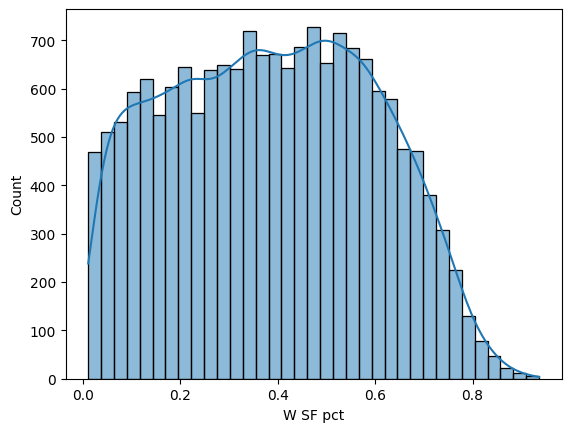

In [12]:
from seaborn import histplot
from warnings import filterwarnings

filterwarnings(action='ignore', category=FutureWarning)

histplot(data=df[(df['Elo White'] > 0) & (df['Elo Black'] > 0) & (df['Score'] != '1/2-1/2') & (df['W SF pct'] > 0)], x='W SF pct', kde=True)

On the other hand, there's probably a critical value here, where above a certain level the Stockfish percentage probably indicates cheating.